In [32]:
from matplotlib import pylab as plt
from Gridworld import Gridworld
import tensorflow as tf
import random
import numpy as np
import keras
from collections import deque
from tensorflow.keras import(
    layers,
    models,
    metrics,
    losses,
    optimizers,
)

In [33]:
# Custom neural network layer designed for a grid game agent.
# Inherits from Keras' Layer class, allowing integration within the Keras framework.
class model(keras.Model):
    def __init__(self):
        # Initialize the parent Layer to ensure proper setup of the underlying mechanisms.
        super().__init__()

        # Define the first dense layer with 150 units.
        self.layer1 = keras.layers.Dense(150, use_bias=False, name='layer1')
        # Define the second dense layer with 100 units.
        self.layer2 = keras.layers.Dense(100, use_bias=True, name='layer2')
        # Define the third dense (output) layer with 4 units (4 because there are 4 possible actions in the game)
        self.layer3 = keras.layers.Dense(4, use_bias=True, name='layer3')

    def call(self, inputs):
        # Forward propagation through the network begins with the first dense layer.
        x = self.layer1(inputs)
        # Apply the ReLU activation function to introduce non-linearity.
        x = tf.nn.relu(x)
        # Pass the output through the second dense layer.
        x = self.layer2(x)
        # Again, apply the ReLU activation function to capture non-linear relationships.
        x = tf.nn.relu(x)

        # Process the data through the final dense layer to produce the network output.
        # Note: No activation function is applied after this layer. This is often
        # intentional in reinforcement learning setups, where raw scores (logits)
        # may be used directly or processed with a softmax/cross-entropy loss externally.
        x = self.layer3(x)
        
        # Return the final computed output.
        return x

# Note:
# The input dimensions for this model are inferred at runtime when the model is first called.
# This dynamic input size handling is a feature of Keras that promotes flexibility in designing models.

In [34]:
action_set = {
    0: 'u',
    1: 'd',
    2: 'l',
    3: 'r',
}

In [35]:
# create an instance of the model while additionally defining loss and optimizer
optimizer = keras.optimizers.SGD(learning_rate=1e-3)
loss_fn = keras.losses.MeanSquaredError()
agent = model()

In [36]:
# Initialize a counter to track the number of training iterations (loops/epochs)
max_moves = 50
#TensorArray being expandable while runtime
loss_list = tf.TensorArray(tf.float32, size=0, dynamic_size=True, clear_after_read=False)
move_list = tf.TensorArray(tf.float32, size=0, dynamic_size=True, clear_after_read=False)
win_list = tf.TensorArray(tf.float32, size=0, dynamic_size=True, clear_after_read=False)
loop_cnt = 0

gamma = 0.9
epsilon = 0.3
epochs = 45000


# Loop over the specified number of epochs
for i in range(epochs):  # B: Iterate through each training epoch
    print('epoch= ', i)
    loop_cnt += 1  # Increment the loop counter for each epoch

    # Initialize a new Gridworld game with a 4x4 grid and a static configuration
    game = Gridworld(size=4, mode='random')  # C

    # Render the game board as a NumPy array, reshape it to a 1x64 vector,
    # and add a small amount of random noise to slightly perturb the state.
    state_ = game.board.render_np().reshape(1, 64) + np.random.rand(1, 64) / 10.0  # D

    # Convert the NumPy state representation to a TensorFlow tensor for model input
    state1 = tf.convert_to_tensor(state_)
    
    # Set a status flag to indicate that the game is ongoing
    status = 1  # F

    # Initialize counters for moves within the current game and to accumulate loss
    mov = 0
    loss_tmp = 0

    # Continue playing until the game signals termination (status != 1)
    while status == 1:  # G

        with tf.GradientTape() as tape:
            mov += 1  # Increment the move counter
            #print(f"move: {mov}")

            # Obtain Q-values by forwarding the current state through the agent's network
            qval = agent(state1)  # H

            # Convert the Q-values tensor to a NumPy array (note: this conversion might reduce performance)
            qval_ = qval.numpy()

            # Epsilon-greedy action selection: with probability epsilon, choose a random action for exploration,
            # otherwise choose the action with the highest Q-value
            if random.random() < epsilon:  # I
                action_ = np.random.randint(0, 4)
            else:
                action_ = np.argmax(qval_)

            #select Q value fitting the selected action:
            X = tf.squeeze(qval)[action_]

            # Map the selected action index to the corresponding action in the predefined action set
            action = action_set[action_]  # J

            # Apply the selected action to the game environment
            game.makeMove(action)  # K

            # Render the updated game state, reshape, and add noise as before
            state2_ = game.board.render_np().reshape(1, 64) + np.random.rand(1, 64) / 10.0
            state2 = tf.convert_to_tensor(state2_)

            # Obtain the reward from the environment after the action
            reward_ = game.reward()

            # Convert the reward to a TensorFlow tensor and cast it to float
            reward = tf.convert_to_tensor(reward_)
            reward = tf.cast(reward, float)

            # Determine if the episode is complete. Here, a positive reward signifies the end of an episode.
            done = True if reward_ > 0 else False

            # Update the current state to the new state
            state1 = state2

            # Compute target Q-values without tracking gradients for the second step
            with tape.stop_recording():
                # Predict Q value out of state2 without gradient recording
                Q2 = agent(state2)
                maxQ2 = tf.math.reduce_max(Q2)

                #Y: new expected q value up to the end of episode.
                if reward_ == -1: #N
                    Y = reward + (gamma * maxQ2)
                else:
                    Y = reward


            #Calculate the loss between predicted Q-values and target Q-values
            loss = loss_fn([X], [Y])  # P
            #print('loss= ', loss)
            loss_tmp = loss_tmp + loss.numpy()

            # Compute gradients of the loss with respect to the agent's trainable weights
            grads = tape.gradient(loss, agent.trainable_weights)
            # Apply the computed gradients to update the agent's weights (currently commented out)
            optimizer.apply_gradients(zip(grads, agent.trainable_weights))

        # After exiting the inner loop, check termination conditions:
        # If a terminal reward is received (reward != -1) or the move count exceeds max_moves, end the game.
        
            if reward != -1 or mov > max_moves:  # O
                print(f"mov: {mov}")
                status = 0
                if reward == 10:
                    win_list = win_list.write(loop_cnt,1)
                else:
                    win_list = win_list.write(loop_cnt,0)


    # Record the cumulative loss for this epoch into loss_list
    loss_list = loss_list.write(loop_cnt, loss_tmp)
    move_list = move_list.write(loop_cnt,mov)
    print(f"loss: {loss_tmp}")


epoch=  0
mov: 51
loss: 47.515586495399475
epoch=  1
mov: 3
loss: 102.30307906866074
epoch=  2
mov: 29
loss: 132.0499151647091
epoch=  3
mov: 1
loss: 95.46286010742188
epoch=  4
mov: 51
loss: 47.222776889801025
epoch=  5
mov: 7
loss: 101.16000187397003
epoch=  6
mov: 1
loss: 100.96204376220703
epoch=  7
mov: 6
loss: 101.27540186047554
epoch=  8
mov: 14
loss: 103.89681375026703
epoch=  9
mov: 1
loss: 104.92385864257812
epoch=  10
mov: 42
loss: 128.27451884746552
epoch=  11
mov: 51
loss: 44.1494981944561
epoch=  12
mov: 5
loss: 92.55408817529678
epoch=  13
mov: 27
loss: 134.38470989465714
epoch=  14
mov: 4
loss: 115.94590133428574
epoch=  15
mov: 2
loss: 92.98771995306015
epoch=  16
mov: 18
loss: 129.61089968681335
epoch=  17
mov: 40
loss: 117.98173183202744
epoch=  18
mov: 51
loss: 40.02444303035736
epoch=  19
mov: 3
loss: 118.22703391313553
epoch=  20
mov: 19
loss: 93.61951237916946
epoch=  21
mov: 47
loss: 164.0016308426857
epoch=  22
mov: 1
loss: 78.71733856201172
epoch=  23
mov: 39


In [37]:
#store weights:
agent.save_weights("Simplenetwork.weights.h5")  # Saves weights in HDF5 format

In [38]:
#saving the list
#saving the list
import json
loss_Simplenetwork = loss_list.stack().numpy().tolist()
with open("loss_Simplenetwork.json","w") as f:
    json.dump(loss_Simplenetwork,f)

move_Simplenetwork = move_list.stack().numpy().tolist()
with open("move_Simplenetwork.json","w") as f:
    json.dump(move_Simplenetwork,f)

win_Simplenetwork = win_list.stack().numpy().tolist()
with open("win_Simplenetwork.json","w") as f:
    json.dump(win_Simplenetwork,f)

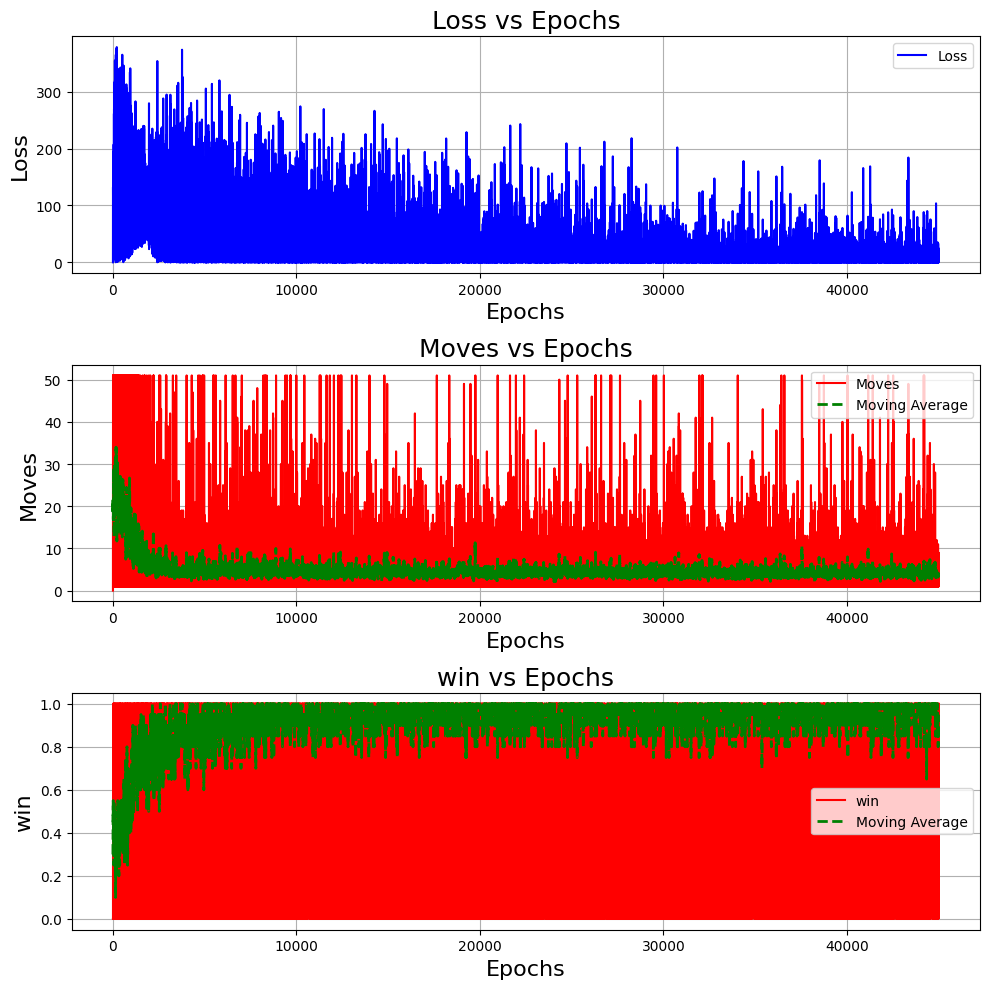

In [39]:
with open("loss_Simplenetwork.json","r") as f:
    loss2 = json.load(f)
with open("move_Simplenetwork.json","r") as f:
    moves = json.load(f)
with open("win_Simplenetwork.json","r") as f:
    win = json.load(f)

# ✅ Ensure moves is a NumPy array
moves = np.array(moves)

# ✅ Define epochs dynamically based on length of moves
epochs = np.arange(len(moves))  # Creates an array [0, 1, 2, ..., len(moves)-1]
# ✅ Compute Moving Average (SMA with window size = 3)
window_size = 20  # Adjust to control smoothness
moving_avg = np.convolve(moves, np.ones(window_size) / window_size, mode='valid')
moving_avg_win = np.convolve(win, np.ones(window_size) / window_size, mode='valid')

# Create a figure with two subplots
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 10))  # Two rows, one column

# ✅ First subplot: Loss over epochs
axes[0].plot(loss2, color='b', label="Loss")
axes[0].set_xlabel("Epochs", fontsize=16)
axes[0].set_ylabel("Loss", fontsize=16)
axes[0].set_title("Loss vs Epochs", fontsize=18)
axes[0].legend()
axes[0].grid(True)

# ✅ Second subplot: Moves over epochs
axes[1].plot(moves, color='r', label="Moves")
axes[1].plot(epochs[:len(moving_avg)], moving_avg, color='g', linestyle='dashed', linewidth=2, label="Moving Average")  # Moving average curve
axes[1].set_xlabel("Epochs", fontsize=16)
axes[1].set_ylabel("Moves", fontsize=16)
axes[1].set_title("Moves vs Epochs", fontsize=18)
axes[1].legend()
axes[1].grid(True)


# ✅ Third subplot: Moves over epochs
axes[2].plot(win, color='r', label="win")
axes[2].plot(epochs[:len(moving_avg_win)], moving_avg_win, color='g', linestyle='dashed', linewidth=2, label="Moving Average")  # Moving average curve
axes[2].set_xlabel("Epochs", fontsize=16)
axes[2].set_ylabel("win", fontsize=16)
axes[2].set_title("win vs Epochs", fontsize=18)
axes[2].legend()
axes[2].grid(True)


# Adjust layout for better spacing
plt.tight_layout()
plt.show()